In [ ]:
# Importação das bibliotecas necessárias
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler

In [14]:
# Carregando o dataset heart.csv
data = pd.read_csv("heart.csv")

data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [15]:
# Algumas estatísticas para entender os dados
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In [16]:
# Entendendo melhor as colunas com variáveis categóricas
# para definir a melhor forma de trabalhar com elas
data[["Sex", "ExerciseAngina", "ST_Slope", "ChestPainType", "RestingECG"]].apply(pd.Series.unique)

Sex                            [M, F]
ExerciseAngina                 [N, Y]
ST_Slope             [Up, Flat, Down]
ChestPainType     [ATA, NAP, ASY, TA]
RestingECG          [Normal, ST, LVH]
dtype: object

In [17]:
# Para as colunas Sex e ExerciseAngina preferi usar uma codificação binária
# Para a ST_Slope escolhi uma codificação ordinal, por entender que há uma ordem entre elas
# Para as outras eu apliquei o one-hot encoding por entender que haviam mais categorias sem hierarquia entre elas
data['Sex'] = data['Sex'].map({'M': 1, 'F': 0})
data['ExerciseAngina'] = data['ExerciseAngina'].map({'Y': 1, 'N': 0})
data['ST_Slope'] = data['ST_Slope'].map({'Up': 2, 'Flat': 1, 'Down': 0})

data = pd.get_dummies(data, columns=['ChestPainType', 'RestingECG'], drop_first=False)

In [18]:
# Verificando como a tabela ficou
data.head()

,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST
0,40,1,140,289,0,172,0,0.0,2,0,False,True,False,False,False,True,False
1,49,0,160,180,0,156,0,1.0,1,1,False,False,True,False,False,True,False
2,37,1,130,283,0,98,0,0.0,2,0,False,True,False,False,False,False,True
3,48,0,138,214,0,108,1,1.5,1,1,True,False,False,False,False,True,False
4,54,1,150,195,0,122,0,0.0,2,0,False,False,True,False,False,True,False


In [19]:
# Nessa caso nosso target é o HeartDisease, que é justamente o que queremos prever
target = "HeartDisease"

# Separação entre os dados da target e das features que serão usadas
X = data.drop(target, axis=1)
y = data[target]

# Verificando como está a distribuição do nosso target para verificar se há desbalanceamento
print("\nDistribuição do target:")
print(y.value_counts(normalize=True))


Distribuição do target:
HeartDisease
1    0.553377
0    0.446623
Name: proportion, dtype: float64


In [20]:
from sklearn.model_selection import train_test_split

# A partir dos dados separados anteriormente, fazemos a divisão dos dados de treino e teste,
# consideraremos aqui 80% da amostra para treino
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Verificando o tamanho que ficaram nossos conjuntos de treino e teste
print(f"\nTamanho do conjunto de treino: {X_train.shape}")
print(f"Tamanho do conjunto de validação: {X_test.shape}")


Tamanho do conjunto de treino: (734, 16)
Tamanho do conjunto de validação: (184, 16)


In [21]:
# Usando o StandardScaler() pata padronizar os dados numéricos da amostra
# Isso faz com que eles possuam média zero e desvio padrão 1.
# Como o KNN que utilizaremos é sensível a escala, isso essa padronização é importante
# Isso evita que, dependendo da escala usada pela coluna, 
# haja predominância de uma feature em detrimento de outras

numeric_cols = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']

scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

print("\nDados de treino transformados:")
print(X_train.head())


Dados de treino transformados:
          Age  Sex  RestingBP  Cholesterol  FastingBS     MaxHR  \
485  0.970012    1   0.339016     0.127137          1 -0.324520   
486  0.122028    1  -1.266031     0.099443          1  1.689837   
117  0.546020    0  -0.159102     1.244113          1 -0.247045   
361 -0.725956    1   1.501291    -1.876035          0 -0.479470   
296 -0.407962    1   0.671094    -1.876035          1  0.101594   

     ExerciseAngina   Oldpeak  ST_Slope  ChestPainType_ASY  ChestPainType_ATA  \
485               1  0.317046         1              False               True   
486               0 -0.440356         2              False               True   
117               1  0.601071         1               True              False   
361               1 -0.819056         1               True              False   
296               1 -0.156330         1               True              False   

     ChestPainType_NAP  ChestPainType_TA  RestingECG_LVH  RestingECG_Normal  \

In [22]:
# Primeiro avaliamos o modelo considerando um valor default de k = 5 para o KNN
# Por meio do KNN são procurados os k pontos de treinamento que se apresentam
# mais próximos de um novo posto testado
# Para ela obtemos uma acurácia de aproximadamente 88%

k = 5
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

# Visualização da Acurácia, Matriz de Confusão e Relatório de Classificação:
print(f"Acurácia (k = 5): {accuracy:.4f}")
print("Matriz de Confusão (k = 5):")
print(confusion_matrix(y_test, y_pred))
print("\nRelatório de Classificação (k = 5):")
print(classification_report(y_test, y_pred))

Acurácia (k = 5): 0.8804
Matriz de Confusão (k = 5):
[[69 13]
 [ 9 93]]

Relatório de Classificação (k = 5):
              precision    recall  f1-score   support

           0       0.88      0.84      0.86        82
           1       0.88      0.91      0.89       102

    accuracy                           0.88       184
   macro avg       0.88      0.88      0.88       184
weighted avg       0.88      0.88      0.88       184



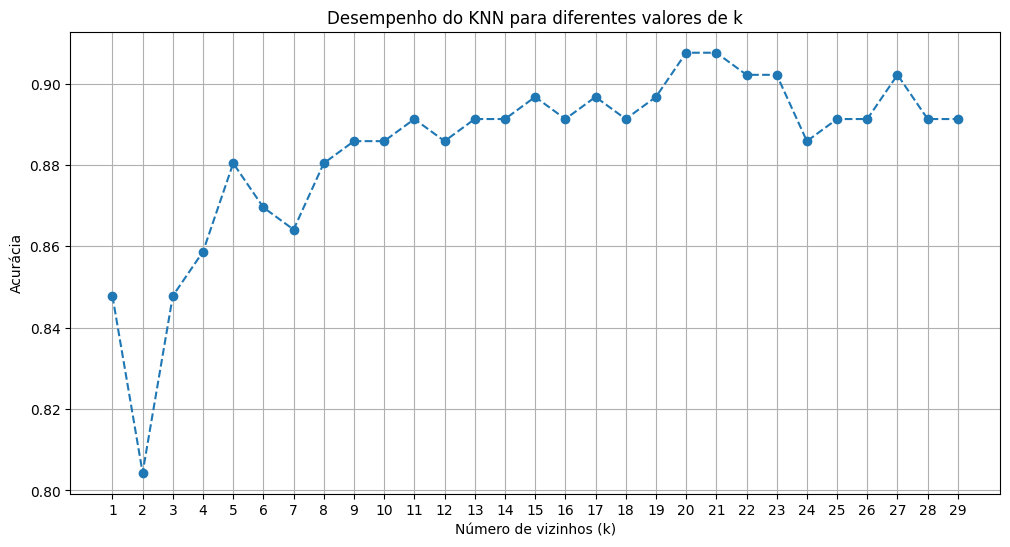

In [23]:
# Porém, se avaliarmos novamente a acurácia do modelo considerando
# agora valores de k entre 1 e 30, conseguimos achar uma acurácia ainda maior
# Usando k = 2, como vemos pelo gráfico, teríamos uma acurácia bem mais baixa
# Também pelo gráfico podemos reparar que o k = 20 e k = 21 possuem um desempenho maior

k_values = range(1, 30)
accuracies = []

# Loop para verificar a acurácia para o range de ks definidos anteriormente
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

# Visualização dos diferentes desempenhos considerando os valores testados de k
plt.figure(figsize=(12, 6))
plt.plot(k_values, accuracies, marker='o', linestyle='--')
plt.title('Desempenho do KNN para diferentes valores de k')
plt.xlabel('Número de vizinhos (k)')
plt.ylabel('Acurácia')
plt.xticks(k_values)
plt.grid(True)
plt.show()

In [24]:
# Selecionando o valor de k com a maior acurácia
best_k = k_values[accuracies.index(max(accuracies))]
print(f"\nMelhor valor para k: {best_k} \nAcurácia: {max(accuracies):.4f}")

# Gerando o relatório para melhor avaliar o desempenho do modelo
# de acordo com o melhor k
print("\nRelatório de Classificação considerando o melhor k:")
best_knn = KNeighborsClassifier(n_neighbors=best_k)
best_knn.fit(X_train, y_train)
y_pred_best = best_knn.predict(X_test)
print(classification_report(y_test, y_pred_best))

# O melhor valor de k para o modelo a partir dessa análise foi o k = 20
# Nesse caso tivemos uma acurácia para o modelo de 90,7%
# Melhor do que a acurácia obtida pelo modelo em que apenas usamos um k default


Melhor valor para k: 20 
Acurácia: 0.9076

Relatório de Classificação considerando o melhor k:
              precision    recall  f1-score   support

           0       0.90      0.89      0.90        82
           1       0.91      0.92      0.92       102

    accuracy                           0.91       184
   macro avg       0.91      0.91      0.91       184
weighted avg       0.91      0.91      0.91       184

